In [1]:
import sys

sys.argv.append(["--max-memory", "8G"])

import datetime
from pathlib import Path

import geopandas as gpd
import pandas as pd
import pyrosm
import seaborn as sns
from r5py import TransportMode, TransportNetwork, TravelTimeMatrixComputer

from aves.data import eod
from aves.visualization.figures import small_multiples_from_geodataframe

GTFS: https://datos.gob.cl/dataset/33245

In [2]:
network = TransportNetwork("../../../data/external/OSM/clipped-scl230101-osm.pbf", '../../../data/external/gtfs/gtfsv40.zip')

In [3]:
network

<Axes: >

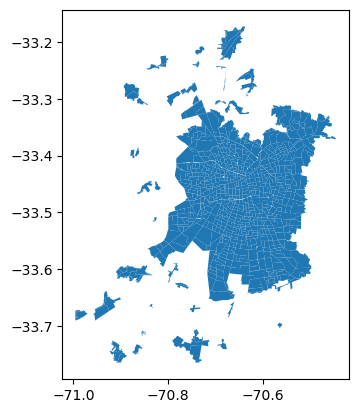

In [4]:
AVES_ROOT = Path("../../..")
OSM_PATH = AVES_ROOT / "data" / "external" / "OSM"
osm_clipped_file = OSM_PATH / "clipped-scl-osm.pbf"

zones = gpd.read_file(AVES_ROOT / "data" / "processed" / "scl_zonas_urbanas.json")
zones.plot()

In [5]:
zones['geometry_original'] = zones['geometry']
zones['geometry'] = zones.centroid

/tmp/ipykernel_8807/3054921321.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones['geometry'] = zones.centroid


<Axes: >

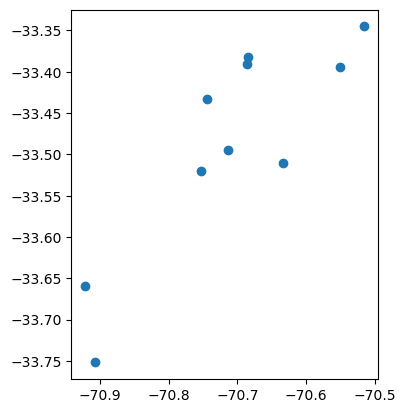

In [6]:
query_areas = zones.sample(10)
query_areas.plot()

In [7]:
query_areas

,ID,AREA,Zona,Com,Comuna,REGION,NOM_REGION,PROVINCIA,NOM_PROVIN,COMUNA,NOM_COMUNA,URBANO,TIPO,NOM_CATEG,SHAPE_Leng,SHAPE_Area,area_m2,geometry,geometry_original
437,313,903.4375,313.0,13114,Las Condes,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13114,LAS CONDES,LAS CONDES,CAPITAL COMUNAL,CIUDAD,0.380999,0.004387,4.333679e+05,POINT (-70.55050 -33.39388),"POLYGON ((-70.55365 -33.39365, -70.55353 -33.3..."
501,336,121.6875,336.0,13115,Lo Barnechea,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13115,LO BARNECHEA,LO BARNECHEA,CAPITAL COMUNAL,CIUDAD,0.549820,0.004797,7.615629e+05,POINT (-70.51637 -33.34522),"POLYGON ((-70.52170 -33.34339, -70.52124 -33.3..."
668,83,75.1250,83.0,13104,Conchalí,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13104,CONCHALÍ,CONCHALÍ,CAPITAL COMUNAL,CIUDAD,0.138248,0.001077,4.188191e+05,POINT (-70.68641 -33.39067),"POLYGON ((-70.68315 -33.39254, -70.68305 -33.3..."
256,821,376.5000,821.0,13601,Talagante,13,REGIÓN METROPOLITANA DE SANTIAGO,136,TALAGANTE,13601,TALAGANTE,TALAGANTE,CAPITAL PROVINCIAL,CIUDAD,0.196917,0.001008,4.133984e+06,POINT (-70.92105 -33.65987),"POLYGON ((-70.93052 -33.65243, -70.93243 -33.6..."
754,66,393.7500,66.0,13102,Cerrillos,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13102,CERRILLOS,CERRILLOS,CAPITAL COMUNAL,CIUDAD,0.204707,0.001628,1.435582e+06,POINT (-70.71412 -33.49434),"POLYGON ((-70.70585 -33.49252, -70.70576 -33.4..."
264,839,610.0000,839.0,13603,Isla de Maipo,13,REGIÓN METROPOLITANA DE SANTIAGO,136,TALAGANTE,13603,ISLA DE MAIPO,ISLA DE MAIPO,CAPITAL COMUNAL,CIUDAD,0.239698,0.000819,2.122062e+06,POINT (-70.90652 -33.75182),"POLYGON ((-70.91341 -33.75700, -70.91075 -33.7..."
309,530,829.1875,530.0,13124,Pudahuel,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13124,PUDAHUEL,PUDAHUEL,CAPITAL COMUNAL,CIUDAD,0.183893,0.001552,4.513360e+05,POINT (-70.74431 -33.43322),"POLYGON ((-70.74613 -33.43641, -70.74664 -33.4..."
718,624,218.9375,624.0,13129,San Joaquín,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13129,SAN JOAQUÍN,SAN JOAQUÍN,CAPITAL COMUNAL,CIUDAD,0.134525,0.000965,5.303000e+05,POINT (-70.63339 -33.51025),"POLYGON ((-70.62916 -33.51423, -70.62987 -33.5..."
187,402,329.3125,402.0,13119,Maipú,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13119,MAIPÚ,MAIPÚ,CAPITAL COMUNAL,CIUDAD,0.359284,0.005556,7.659215e+05,POINT (-70.75287 -33.51988),"POLYGON ((-70.75565 -33.51643, -70.75557 -33.5..."
673,91,258.7500,91.0,13104,Conchalí,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13104,CONCHALÍ,CONCHALÍ,CAPITAL COMUNAL,CIUDAD,0.138248,0.001077,4.659743e+05,POINT (-70.68506 -33.38229),"POLYGON ((-70.68639 -33.38585, -70.68654 -33.3..."


In [8]:


cost_computer = TravelTimeMatrixComputer(
    network,
    origins=query_areas.rename(columns={'ID': 'id'}),
    destinations=zones.rename(columns={'ID': 'id'}).drop_duplicates(subset=['id']),
    departure=datetime.datetime(2018, 7, 10, 8, 30),
    transport_modes=[TransportMode.TRANSIT, TransportMode.WALK],
)

In [9]:
travel_time_matrices = cost_computer.compute_travel_times()

In [10]:
travel_time_matrices

,from_id,to_id,travel_time
0,313,103,84.0
1,313,104,80.0
2,313,106,93.0
3,313,115,86.0
4,313,116,84.0
...,...,...,...
8175,91,366,74.0
8176,91,364,82.0
8177,91,369,81.0
8178,91,365,74.0


In [11]:

cost_matrix = pd.pivot_table(travel_time_matrices, index='from_id', columns='to_id', values='travel_time')
cost_matrix

to_id,1,2,3,4,5,6,7,8,9,10,...,837,838,839,840,841,842,846,847,848,861
from_id,,,,,,,,,,,,,,,,,,,,,
66,64.0,60.0,61.0,55.0,57.0,51.0,55.0,62.0,60.0,56.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,NaN
83,34.0,39.0,45.0,42.0,45.0,45.0,53.0,41.0,48.0,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,113.0,NaN
91,38.0,43.0,48.0,46.0,48.0,49.0,54.0,44.0,48.0,44.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.0,NaN
313,60.0,60.0,57.0,55.0,53.0,56.0,55.0,58.0,56.0,53.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
336,97.0,96.0,93.0,92.0,89.0,91.0,91.0,93.0,92.0,89.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
402,54.0,49.0,50.0,45.0,47.0,50.0,55.0,56.0,51.0,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0,NaN
530,44.0,39.0,40.0,35.0,36.0,40.0,45.0,46.0,40.0,37.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.0,NaN
624,58.0,57.0,55.0,52.0,50.0,52.0,52.0,53.0,51.0,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.0,NaN
821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,41.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.0


<Axes: xlabel='to_id', ylabel='from_id'>

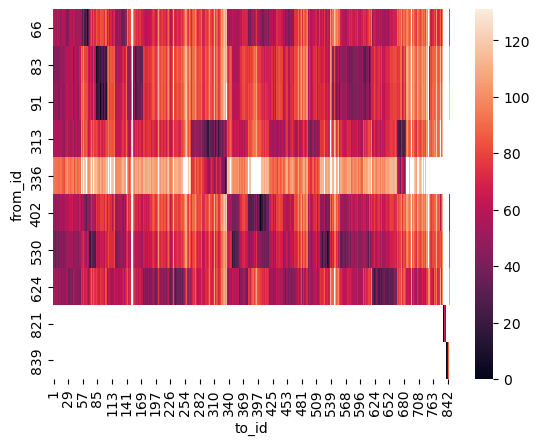

In [13]:
sns.heatmap(pd.pivot_table(travel_time_matrices, index='from_id', columns='to_id', values='travel_time'))

In [14]:
zones_orig = zones.drop('geometry', axis=1).rename({'geometry_original': 'geometry'}, axis=1)

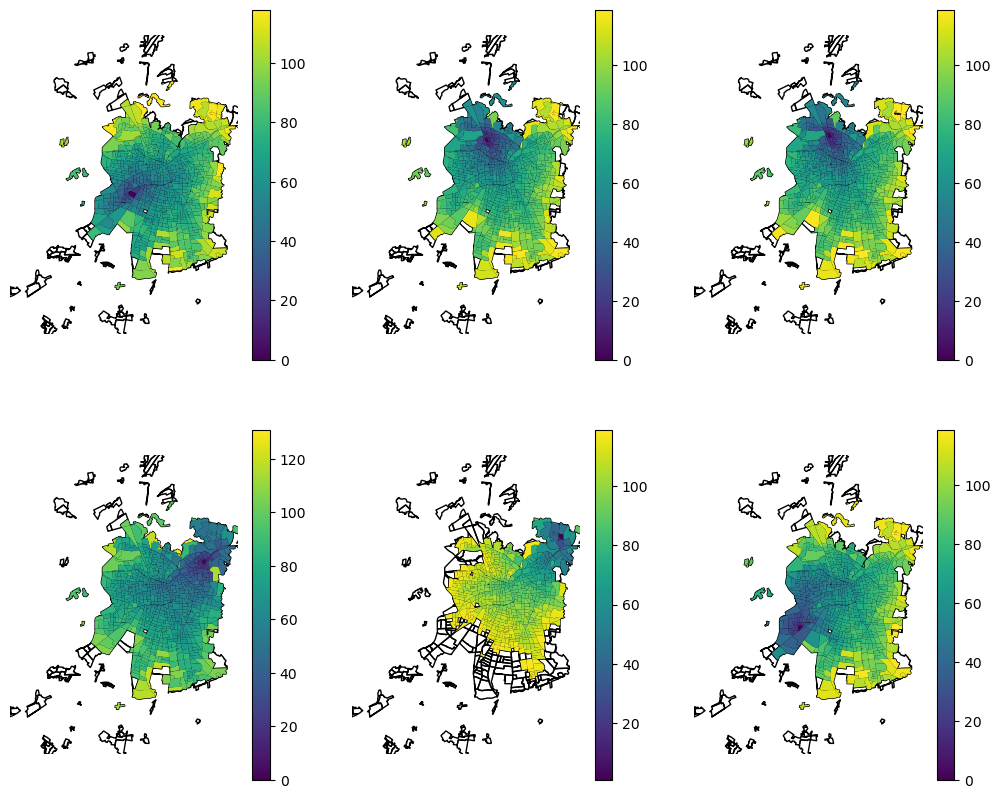

In [15]:
fig, axes = small_multiples_from_geodataframe(zones, 6, col_wrap=3)

for area_id, ax in zip(cost_matrix.index.values, axes.flatten()):
    zones_orig.plot(edgecolor='black', facecolor='none', ax=ax)
    zones_orig.join(cost_matrix.loc[area_id].rename('cost'), on='ID').plot(column='cost', ax=ax, legend=True)

## Oportunidades acumuladas

¿A cuántas _oportunidades_ se puede acceder dada una restricción de costo?

Problemos con _oportunidades_ = colegios

In [16]:
osm = pyrosm.OSM(str(osm_clipped_file))

In [17]:
schools = osm.get_pois(custom_filter={"amenity": ["school"]})
schools

,timestamp,id,changeset,lon,tags,visible,lat,version,addr:city,addr:country,...,wikipedia,geometry,osm_type,addr:full,building,building:levels,internet_access,landuse,school,start_date
0,1631928686,274474456,0.0,-70.734291,"{""contact:email"":""aguerrero@sip.cl"",""school:ty...",False,-33.408539,6,None,None,...,None,POINT (-70.73429 -33.40854),node,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1246942797,436055942,0.0,-70.628784,None,False,-33.444019,1,None,None,...,None,POINT (-70.62878 -33.44402),node,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1248287842,445769836,0.0,-70.504509,None,False,-33.392895,1,None,None,...,None,POINT (-70.50451 -33.39289),node,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1261442868,597928362,0.0,-70.480759,None,False,-33.607044,2,None,None,...,None,POINT (-70.48076 -33.60704),node,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1268234666,663684592,0.0,-70.822083,None,False,-33.455669,1,None,None,...,None,POINT (-70.82208 -33.45567),node,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2844,1563001113,16569607258,0.0,NaN,"{""barrier"":""wall"",""type"":""multipolygon""}",NaN,NaN,2,None,None,...,NaN,"LINESTRING (-70.57548 -33.59867, -70.57474 -33...",relation,NaN,None,NaN,NaN,NaN,NaN,NaN
2845,1569339196,17462356445,0.0,NaN,"{""type"":""multipolygon""}",NaN,NaN,1,None,None,...,NaN,"POLYGON ((-70.57091 -33.54359, -70.57064 -33.5...",relation,NaN,None,NaN,NaN,NaN,NaN,NaN
2846,1571174853,17724918017,0.0,NaN,"{""type"":""multipolygon""}",NaN,NaN,1,None,None,...,NaN,"POLYGON ((-70.55614 -33.53609, -70.55554 -33.5...",relation,NaN,None,NaN,NaN,NaN,NaN,NaN
2847,1589371751,20115722916,0.0,NaN,"{""contact:email"":""mgonzalez@lamaisonnette.cl"",...",NaN,NaN,1,Vitacura,CL,...,NaN,"POLYGON ((-70.57537 -33.38581, -70.57547 -33.3...",relation,NaN,None,NaN,NaN,NaN,NaN,NaN


<Axes: >

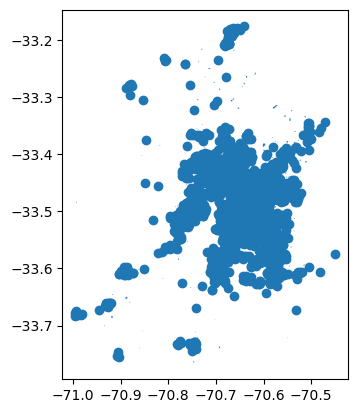

In [18]:
schools.plot()

In [19]:
for area_id in cost_matrix.index.values:
    reachable_areas = cost_matrix.loc[area_id][(cost_matrix.loc[area_id] <= 30)]
    #print(len(reachable_areas))
    reachable_zones = zones_orig[zones_orig['ID'].isin(reachable_areas.index)]
    reachable_pois = gpd.sjoin(schools, reachable_zones, predicate='within')
    print(f'Area #{area_id} alcanza {len(reachable_areas)} áreas, accediendo a {len(reachable_pois)} colegios')
    #break

Area #66 alcanza 10 áreas, accediendo a 27 colegios
Area #83 alcanza 25 áreas, accediendo a 64 colegios
Area #91 alcanza 24 áreas, accediendo a 64 colegios
Area #313 alcanza 24 áreas, accediendo a 36 colegios
Area #336 alcanza 3 áreas, accediendo a 4 colegios
Area #402 alcanza 20 áreas, accediendo a 128 colegios
Area #530 alcanza 30 áreas, accediendo a 129 colegios
Area #624 alcanza 22 áreas, accediendo a 71 colegios
Area #821 alcanza 1 áreas, accediendo a 20 colegios
Area #839 alcanza 4 áreas, accediendo a 8 colegios


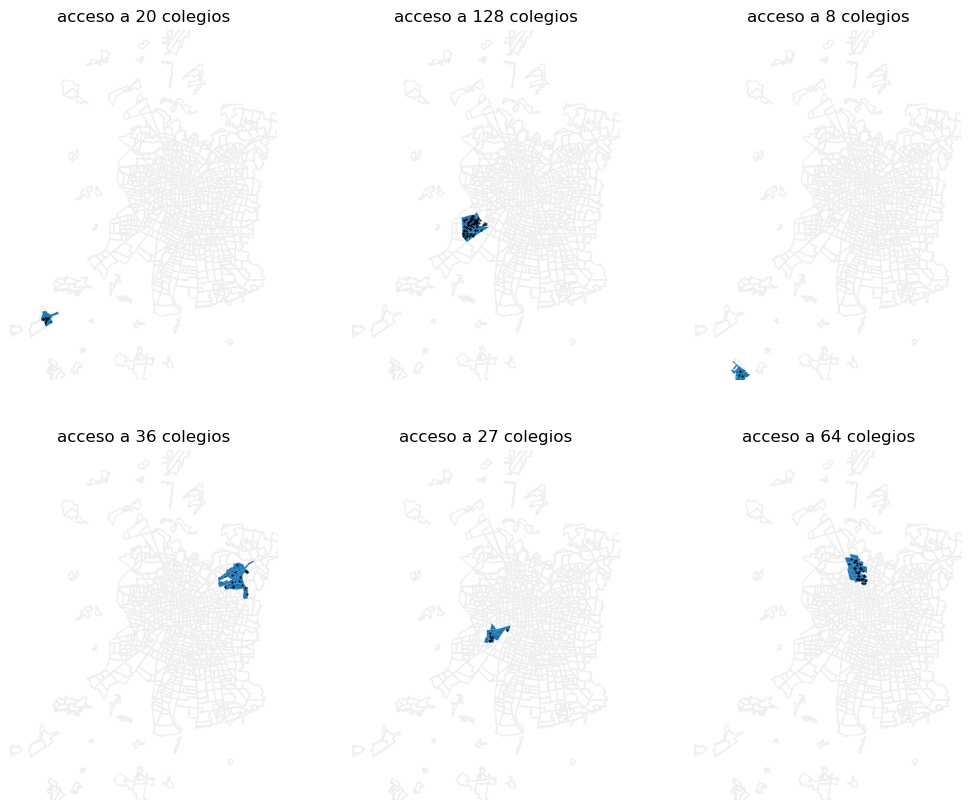

In [20]:
fig, axes = small_multiples_from_geodataframe(zones, 6, col_wrap=3)

for ax, area_id in zip(axes.flatten(), cost_matrix.sample(6).index.values):
    reachable_areas = cost_matrix.loc[area_id][(cost_matrix.loc[area_id] <= 30)]
    reachable_zones = zones_orig[zones_orig['ID'].isin(reachable_areas.index)]
    reachable_pois = gpd.sjoin(schools, reachable_zones, predicate='within')

    zones_orig.plot(facecolor='none', edgecolor='#efefef', ax=ax)
    reachable_zones.plot(ax=ax)
    reachable_pois.plot(color='black', ax=ax, marker='.', markersize=1)
    ax.set_title(f'acceso a {len(reachable_pois)} colegios')

## Costo mínimo de viaje

En vez de la cantidad de oportunidades disponibles bajo un costo, ¿cuál es el costo mínimo para alcanzar una oportunidad?

In [21]:
travel_time_matrices

,from_id,to_id,travel_time
0,313,103,84.0
1,313,104,80.0
2,313,106,93.0
3,313,115,86.0
4,313,116,84.0
...,...,...,...
8175,91,366,74.0
8176,91,364,82.0
8177,91,369,81.0
8178,91,365,74.0


<Axes: >

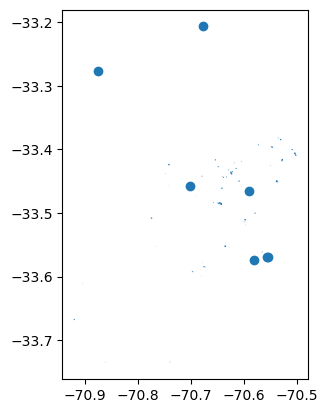

In [22]:
hospitals = osm.get_pois(custom_filter={"amenity": ["hospital"]})
hospitals.plot()

<Axes: >

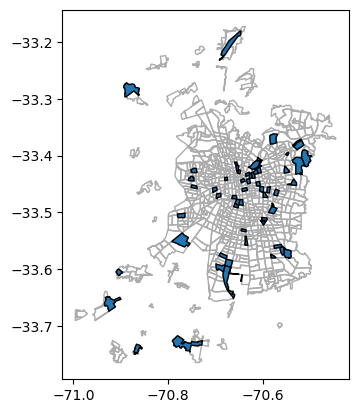

In [23]:
zones_with_hospitals = zones_orig[zones_orig['ID'].isin(gpd.sjoin(hospitals, zones_orig, predicate='within')['ID'].unique())]
ax = zones_orig.plot(facecolor='none', edgecolor='#abacab')
zones_with_hospitals.plot(ax=ax, edgecolor='black')

In [24]:
min_cost_accessibility = travel_time_matrices[travel_time_matrices['to_id'].isin(zones_with_hospitals['ID'])].groupby('from_id')['travel_time'].min()
min_cost_accessibility

from_id
66     44.0
83     37.0
91     33.0
313    10.0
336    37.0
402    28.0
530    16.0
624    33.0
821     0.0
839    99.0
Name: travel_time, dtype: float64

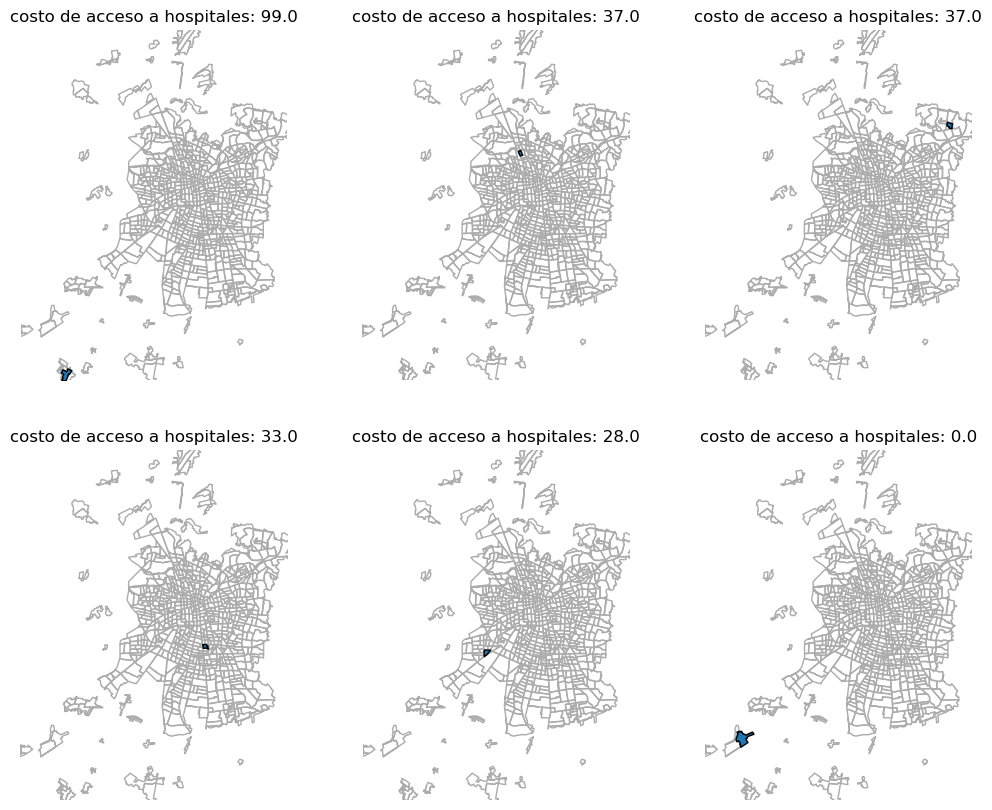

In [25]:
fig, axes = small_multiples_from_geodataframe(zones, 6, col_wrap=3)

for ax, area_id in zip(axes.flatten(), cost_matrix.sample(6).index.values):
    zones_orig.plot(facecolor='none', edgecolor='#abacab', ax=ax)
    zones_orig[zones_orig['ID'] == area_id].plot(ax=ax, edgecolor='black')
    ax.set_title(f'costo de acceso a hospitales: {min_cost_accessibility.loc[area_id]}')

## Métodos competitivos

Que algo esté al alcance no significa que se pueda usar. Por ejemplo, los hospitales se pueden llenar. Por tanto, es necesario considerar ese factor.

Para esto podemos usar la biblioteca `access` de PySAL: https://pysal.org/access/index.html

En particular calcularemos el modelo _Rational Agent Access Model_ (RAAM), que optimiza la distribución de pacientes en proveedores al minimizar la congestión y el tiempo de viaje de manera simultánea [(Saxon and Snow 2019)](https://www.tandfonline.com/doi/abs/10.1080/24694452.2019.1629870)


In [26]:
full_cost_computer = TravelTimeMatrixComputer(
    network,
    # todos los orígenes
    origins=zones.rename(columns={'ID': 'id'}).drop_duplicates(subset=['id']),
    # solo celdas con hospitales
    destinations=zones[zones['ID'].isin(zones_with_hospitals['ID'])].rename(columns={'ID': 'id'}).drop_duplicates(subset=['id']),
    departure=datetime.datetime(2018, 7, 10, 8, 30),
    transport_modes=[TransportMode.TRANSIT, TransportMode.WALK],
)

In [27]:
full_travel_time_matrices = full_cost_computer.compute_travel_times()

In [28]:
full_travel_time_matrices.head()

,from_id,to_id,travel_time
0,103,118,32.0
1,103,770,65.0
2,103,763,23.0
3,103,773,35.0
4,103,204,54.0


In [29]:


people = eod.read_people()
homes = eod.read_homes()

In [30]:
poblacion_zonas = (
    homes.join(
        people.groupby("Hogar")["FactorPersona"].sum(), on="Hogar"
    )
    .groupby("Zona")["FactorPersona"]
    .sum()
    .rename("poblacion")
)

poblacion_zonas

Zona
1       6485.42037
2       3522.10424
3       2321.45969
4       3547.85187
5       3435.41141
          ...     
857    11297.11394
858    19283.57915
859    24079.31082
860    13784.38253
861     8939.69403
Name: poblacion, Length: 790, dtype: float64

In [31]:
from access import Access

<Axes: >

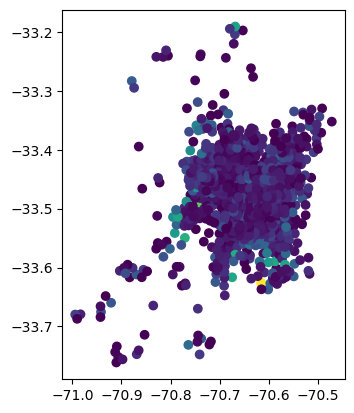

In [32]:
zonas_poblacion = zones.drop_duplicates(subset='ID').join(poblacion_zonas, how='left', on='ID').fillna(0)
zonas_poblacion.plot(column='poblacion')

<Axes: >

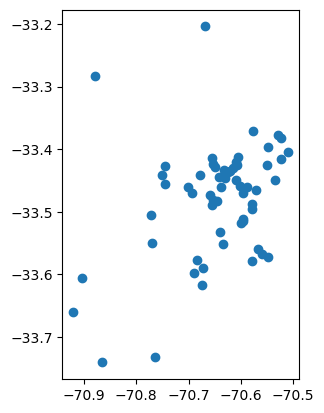

In [33]:
oferta_hospitales = gpd.sjoin(hospitals, zones_orig, predicate='within').groupby('ID').size().rename('hospitales')
zones_supply = zones.drop_duplicates(subset='ID').join(oferta_hospitales, on='ID', how='inner')
zones_supply.plot()

In [34]:
A = Access(
    demand_df=zonas_poblacion,
    demand_index="ID",
    demand_value="poblacion",
    supply_df=zones_supply,
    supply_index="ID",
    supply_value="hospitales",
    cost_df=full_travel_time_matrices,
    cost_origin="from_id",
    cost_dest="to_id",
    cost_name="travel_time",
)

In [35]:
zone_accesibility = A.raam(name="raam", tau=60).dropna()

<Axes: >

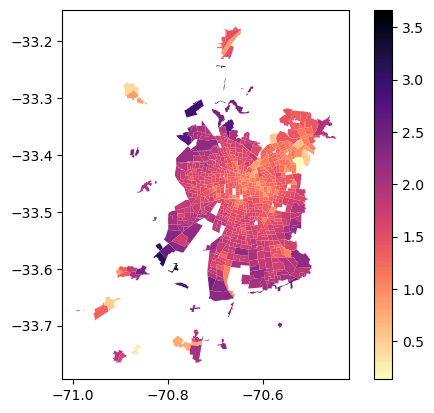

In [36]:
zones_orig.join(zone_accesibility, on='ID', how='inner').plot(column='raam_hospitales', legend=True, cmap='magma_r')